# Predict Weights with new datasets
- validation data was used
- inception-resnet-v2 added
- formed 2 types of scale

In [1]:
import os
import fnmatch
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

rootpath = '/media/share/data/Tremella_fuciformis/'

# Generat Dataframe

In [2]:
# For DL purpose, high qulity image
def label_cleaning(root_path):
    
    filename = sorted([idx for idx in Path(root_path).glob('*/*.xlsx')])

    df_all = pd.DataFrame([])
    for idx in filename[10:]:
        df = pd.read_excel(idx, header=1)
        sn = pd.DataFrame(df['號碼.1'].str.split('-').str[0])
        cansn = pd.DataFrame(df['號碼.1'].str.split('-').str[1])
        df_temp = pd.concat([sn, cansn, df['平均單朵重量'], df['取樣天數']], 1)
        df_temp = df_temp.dropna()
        # add production sn
        psn = pd.DataFrame(np.repeat([os.path.basename(idx).split('.')[0]], len(df_temp)), columns=['PSN'])
        df_temp = pd.concat([psn.reset_index(drop=True), df_temp.reset_index(drop=True)], 1)

        df_all = pd.concat([df_all, df_temp], 0)

    df_all.columns = ['PSN', 'SN', 'CanSN', 'Weight', 'Days']
    
    return df_all

In [3]:
df_train = label_cleaning(rootpath)

# delet mis-matched label
df_train['SN'] = pd.to_numeric(df_train['SN'], errors='coerce')
df_train = df_train.dropna()
df_train['SN'] = pd.to_numeric(df_train['SN'], downcast='integer')

df_train.reset_index(drop=True, inplace=True)
df_train.sample(5)

,PSN,SN,CanSN,Weight,Days
195,T8-171229,7,5,62.000000,38.0
160,T8-171229,5,11,55.590909,38.0
203,T8-171229,7,13,54.583333,38.0
60,T8-171227,4,3,44.541667,36.0
113,T8-171227,7,18,50.375000,36.0


# Image Preprocess and Augmentation steps

In [4]:
!pip install imgaug

In [18]:
def img_proc(img):
    
    import numpy as np
    from skimage.color import rgb2gray
    from skimage.feature import canny
    from skimage.morphology import disk, closing
    from skimage.morphology import remove_small_objects
    from skimage.measure import label, regionprops

    img1 = rgb2gray(img)
    img2 = canny(img1)
    img3 = closing(img2, disk(5))
    img4 = remove_small_objects(img3)

    # search largest area
    label_img = label(img4)

    bbarea = []
    for region in regionprops(label_img):
        bbarea.append(region.area)

    minr, minc, maxr, maxc = regionprops(label_img)[bbarea.index(np.max(bbarea))].bbox
    crop_img = img[minr:maxr, minc:maxc]
    
    return crop_img


def img_gen(indexlist):
    
    from skimage.transform import resize
    import imgaug as ia
    from imgaug import augmenters as iaa
    from random import shuffle
    
    ia.seed(np.random.randint(1, 2**10))
    
    # aug_parameters
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Affine(
#             scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 90-110% of their size, individually per axis
#             translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -10 to +10 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            mode='edge'
        ),
        iaa.GaussianBlur((0.0, 1.0))
    ], random_order=True)
    
    step = 0 
    batchsize = 8 * gdev_count
    rows, cols = 256, 256
    
    while True:
        img_file1 = []
        label = []
    
        for i in range(batchsize):
            subpath = os.path.join(rootpath, df_train['PSN'].iloc[indexlist[step]])
            sn = str(df_train['SN'].iloc[indexlist[step]])
            csn = str(df_train['CanSN'].iloc[indexlist[step]])
            img = plt.imread(subpath + '/' + sn + '/' + csn + '.JPG')
            
            if img.shape[0] > img.shape[1]:
                img = np.transpose(img, (1, 0, 2))
                
            # roi segmentation
            img = img_proc(img)

            # augment
            img = seq.augment_image(img)
            
            # resize
            img_file1.append(resize(img, (rows, cols, 3), mode='edge'))

            # load y value
            label.append(df_train['Weight'].iloc[indexlist[step]])
            
            step += 1
            if step >= len(indexlist):
                step = 0

        # yield
        yield np.array(img_file1), np.array(label)

In [22]:
# from skimage.transform import resize
# import imgaug as ia
# from imgaug import augmenters as iaa
# from random import shuffle
# from multiprocessing import Pool, cpu_count
# import itertools
# from random import sample

# def img_proc(idx):
    
#     img_file1 = []
#     label = []
#     ia.seed(np.random.randint(1, 2**10))
    
#     # aug_parameters
#     seq = iaa.Sequential([
#         iaa.Affine(
#             scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 90-110% of their size, individually per axis
#             translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -10 to +10 percent (per axis)
#             rotate=(-10, 10), # rotate by -10 to +10 degrees
#             mode='edge'
#         ),
#         iaa.GaussianBlur((0.0, 2.0)), # Blur images using gaussian function
#     ], random_order=True)
    

#     subpath = os.path.join(rootpath, df_train['PSN'].iloc[idx])
#     sn = str(df_train['SN'].iloc[idx])
#     csn = str(df_train['CanSN'].iloc[idx])
#     img = plt.imread(subpath + '/' + sn + '/' + csn + '.JPG')

#     if img.shape[0] > img.shape[1]:
#         img = np.transpose(img, (1, 0, 2))

#     # augment
#     img = seq.augment_image(img)

#     # resize
#     img_file1.append(resize(img, (299, 299, 3), mode='reflect'))

#     # load y value
#     label.append(df_train['Weight'].iloc[idx])

#     return img_file1, label

# def img_gen(indexlist, batchsize):
#     while True:
#         chosen = sample(list(indexlist), batchsize)

#         img_file = []
#         label = []
#         for c in chosen:
#             img_file_one, label_one = img_proc(c)
#             img_file += [img_file_one]
#             label += [label_one]

#         img_file = list(itertools.chain(*img_file))
#         label = list(itertools.chain(*label))

#         yield np.array(img_file), np.array(label)

# Setup GPU Parameters

In [6]:
## MultiGPU Code
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

import keras.utils.training_utils
from keras.utils import multi_gpu_model
gdev = keras.utils.training_utils._get_available_devices()
gdev_count = 0
for i, n in enumerate(gdev):
    if 'device:GPU' in n:
        gdev_count+=1
if gdev_count > 0:
    print('Found {} GPUs, will attempt to use all of them.'.format(gdev_count))
else:
    gdev_count=1
    print('Did not find any GPUs, this will be SLOW!')

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 8 GPUs, will attempt to use all of them.


# CNN models (Densenet-121)

In [13]:
import keras.backend as K
from keras.applications.densenet import DenseNet121 as basenet1
# from keras.applications.inception_resnet_v2 import InceptionResNetV2 as basenet2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Average
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

K.clear_session()
base_model1 = basenet1(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
x = GlobalAveragePooling2D()(base_model1.output)
x = Dense(1, activation='relu')(x)

smodel = Model(inputs=base_model1.input, outputs=x)
smodel.summary()

# Multimodel
if gdev_count > 1:
    model = multi_gpu_model(smodel, gdev_count)
    model.summary()
else:
    model = smodel

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [15]:
# self identified index
def acc1(y_true, y_pred):
    return K.mean(K.less_equal(K.abs(y_pred - y_true), K.ones_like(y_true)*5), axis=-1)
def acc2(y_true, y_pred):
    return K.mean(K.less_equal(K.abs(y_pred - y_true), K.ones_like(y_true)*10), axis=-1)
def acc3(y_true, y_pred):
    return K.mean(K.less_equal(K.abs(y_pred - y_true), K.ones_like(y_true)*15), axis=-1)

model.compile(optimizer='adam', loss='mse', metrics=[acc1, acc2, acc3])

# Trainning

In [16]:
from sklearn.model_selection import KFold

n_flod = 5

kf = KFold(n_flod, shuffle=True, random_state=np.random)
for train_idx, val_idx in kf.split(df_train):
    break
    
print(len(train_idx))

174


In [45]:
model.compile(optimizer=Adam(lr=0.02), loss='mse', metrics=[acc1, acc2, acc3])

In [19]:
# model.load_weights('t8_loss.hdf5')

model_checkpoint1 = ModelCheckpoint('t8_mse-val_acc2.hdf5',
                                   monitor='val_acc2', save_best_only=True, save_weights_only=True)
model_checkpoint2 = ModelCheckpoint('t8_mse-val_loss.hdf5',
                                    monitor='val_loss', save_best_only=True, save_weights_only=True)

# adlr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=1e-6)
model_earlystop = EarlyStopping(patience=64, monitor='loss')

train_history = model.fit_generator(img_gen(train_idx), 
                                    epochs=2**3, steps_per_epoch=4, 
                                    validation_data=img_gen(val_idx), 
                                    validation_steps=2,
                                    verbose=2, 
                                    callbacks=[model_checkpoint1, 
                                               model_checkpoint2, 
                                               model_earlystop])

Epoch 1/8
4/4 [==============================] - 2139s 535s/step - loss: 1892.4403 - acc1: 0.0000e+00 - acc2: 0.0117 - acc3: 0.0273 - val_loss: 1569.2609 - val_acc1: 0.0078 - val_acc2: 0.0312 - val_acc3: 0.1250
Epoch 2/8
4/4 [==============================] - 2140s 535s/step - loss: 1218.6184 - acc1: 0.0195 - acc2: 0.0781 - acc3: 0.1680 - val_loss: 1537.8705 - val_acc1: 0.0156 - val_acc2: 0.0391 - val_acc3: 0.0938
Epoch 3/8
4/4 [==============================] - 2095s 524s/step - loss: 1038.8126 - acc1: 0.0586 - acc2: 0.1367 - acc3: 0.2305 - val_loss: 1473.3282 - val_acc1: 0.0234 - val_acc2: 0.0625 - val_acc3: 0.1328
Epoch 4/8
4/4 [==============================] - 2127s 532s/step - loss: 907.7643 - acc1: 0.0508 - acc2: 0.1562 - acc3: 0.2500 - val_loss: 1490.0981 - val_acc1: 0.0156 - val_acc2: 0.0859 - val_acc3: 0.1875
Epoch 5/8
4/4 [==============================] - 2013s 503s/step - loss: 863.8938 - acc1: 0.0703 - acc2: 0.1797 - acc3: 0.2695 - val_loss: 989.0086 - val_acc1: 0.1094 - 

# Evaluation

In [ ]:
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

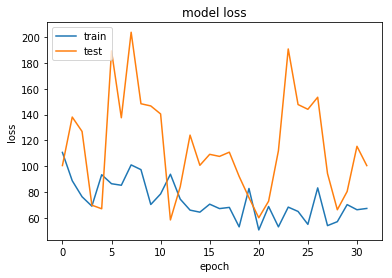

In [24]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
model.load_weights('fungus-test20180201-smcw-16-0.8467.hdf5')
model.evaluate(X_val, y_val)

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_val).argmax(axis=-1)
print(classification_report(y_val.argmax(axis=-1), y_pred, target_names=['A-60', 'B-60']))

In [18]:
model.load_weights('t8_val_loss.hdf5')
# model.save('t8_weight.hdf5')

In [52]:
modelx = model.get_layer('model_1')

In [53]:
modelx.save('t8_weight.h5')

# Prediction

In [ ]:
img = plt.imread('/media/share/data/Tremella_fuciformis/T8-170705/image_5.jpg')
img = resize(img, (256, 256, 3), mode='reflect')
# img = img[np.newaxis, :, :, :]

In [ ]:
y_pred = model.predict(img)

# Testing

In [19]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from skimage.transform import resize
import fnmatch

# model = load_model('/media/share/jiaxin_cmu/Tremella_fuciformis_v1/t8_weight.h5')
testpath = '/media/share/data/Tremella_fuciformis/validation/'
valdir = os.listdir(testpath)
valdir.remove('prediction_T8.csv')
test_img = []

for idx in valdir:
    subpath = os.path.join(testpath, idx)
    subdir = fnmatch.filter(os.listdir(subpath), '*_val')
    for iidx in subdir:
        canpath = os.path.join(subpath, iidx)
        candir = os.listdir(canpath)
        for jdx in candir:
            imgpath = os.path.join(canpath, jdx)
            images = fnmatch.filter(os.listdir(imgpath), '*.JPG')
            SN = idx + '/' + iidx + '/' + jdx
            test_img.append((SN, images))
        
test_df = pd.DataFrame(test_img, columns=['SN', 'image'])

In [ ]:
y_pred = []

for idx in range(len(test_df)):
    filepath = os.path.join(testpath, test_df['SN'].iloc[idx])
    for iidx in test_df['image'].iloc[idx]:
        img = plt.imread(filepath + '/' + iidx)
        if img.shape[0] > img.shape[1]:
            img = np.transpose(img, (1, 0, 2))
        img = [resize(img, (224, 224, 3), mode='reflect')[np.newaxis, :, :, :], resize(img, (299, 299, 3), mode='reflect')[np.newaxis, :, :, :]]
#         img = img[np.newaxis, :, :, :]
        y_pred.append((test_df['SN'].iloc[idx], iidx, model.predict(img)))

In [ ]:
y_pred

In [ ]:
%%javascript
Jupyter.notebook.session.delete();